# **<font color=turquoise>To Recall or Not to Recall: That Is the Question for CNN-Based Alzheimer's Disease Detection Using RecallNET and MRI Imaging</font>**

##### <font color=white>Rahil Radia and Amy Scholl</font>

### **<font color=red> install packages</font>**

In [1]:
%pip install tensorflow
%pip install keras
%pip install imblearn
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### <font color=orange> import libraries </font>

In [2]:
import numpy as np
import random

#   Plotting
import seaborn as sns
import matplotlib.pyplot as plt


#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import tensorflow_addons as tfa

#   count each class samples
from collections import Counter

#   callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

#   evaluate precison recall and f1-score of each class of model
from sklearn.metrics import classification_report
#   Show performance of a classification model
from sklearn.metrics import confusion_matrix

#   Different layers
from keras.initializers import GlorotUniform
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import GroupNormalization
from tensorflow.keras.layers import Attention

# split dataset to train, validation and test set
from sklearn.model_selection import train_test_split

#   callbacks
from keras import callbacks

#   SMOTETomek from imblance library
from imblearn.combine import SMOTETomek

#   Optimizer
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import roc_curve, auc
from itertools import cycle

c:\Users\amyti\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### <font color=orange> define dataset directory and class names </font>

In [3]:
## Set Path Here before running the code
WORKING_DIRECTORY =  ".\dataset"

##  Name of classes 
CLASSES = ['MildDemented',
           'ModerateDemented',
           'NonDemented',
           'VeryMildDemented']

### <font color=orange> load image data, rescale images, separate from data generator, and label One Hot encoding </font>

In [4]:
X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(176, 208),batch_size=6400, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 6400 images belonging to 4 classes.


In [5]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (6400, 176, 208, 3)
Labels shape :	 (6400, 4)


### <font color=orange> create a sampled unbalanced dataset </font>

In [6]:
#   reshaping the images to 1D
X = X.reshape(-1, 176 * 208 * 3)

# create unbalanced dataset and dataset used in rebalancing
X, unbal_x, y, unbal_y = train_test_split(X, y, test_size=0.1)
unbal_x = unbal_x.reshape(-1, 176, 208, 3)

# unbalanced data
unbalanced_samples = len(unbal_x)
print("Number of samples in unbalanced dataset: \t", sorted(Counter(np.argmax(unbal_y, axis = 1)).items()))


Number of samples in unbalanced dataset: 	 [(0, 83), (1, 8), (2, 334), (3, 215)]


### <font color=orange> use SMOTETomek to balance the remaining dataset </font>

In [7]:
#   Oversampling method to remove imbalance class problem
X, y = SMOTETomek().fit_resample(X, y)

#   reshape images to images size of 208, 176, 3
X = X.reshape(-1, 176, 208, 3)

samples_after = len(X)
print("Number of samples after SMOTETomek :\t", sorted(Counter(np.argmax(y, axis=1)).items()))

Number of samples after SMOTETomek :	 [(0, 2866), (1, 2866), (2, 2866), (3, 2866)]


### <font color=orange> split balanced dataset for training, validation, and testing </font>

In [8]:
#   20% split to validation and 80% split to train set
X_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)

#   20% split to test from 80% of train and 60% remains in train set
X_train, x_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.2)

# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))
print("Unbalanced\t",sorted(Counter(np.argmax(unbal_y, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 1870), (1, 1784), (2, 1850), (3, 1832)]
Validation	 [(0, 542), (1, 594), (2, 564), (3, 593)]
Test      	 [(0, 454), (1, 488), (2, 452), (3, 441)]
Unbalanced	 [(0, 83), (1, 8), (2, 334), (3, 215)]


In [9]:
# free up memory
del X, y

## **<font color=orange> RecallNET model </font>**

### <font color=orange> architecture </font>

In [10]:
init = GlorotUniform

RecallNET = Sequential()

RecallNET.add(Input(shape=(176, 208, 3)))

RecallNET.add(Convolution2D(16, 1, kernel_initializer=init))
RecallNET.add(GroupNormalization(groups = -1))
RecallNET.add(ReLU())
RecallNET.add(AveragePooling2D(pool_size=(2,2)))

RecallNET.add(Convolution2D(32, 5, kernel_initializer=init))
RecallNET.add(GroupNormalization(groups = -1))
RecallNET.add(ReLU())
RecallNET.add(AveragePooling2D(pool_size=(2,2)))

RecallNET.add(Convolution2D(64, 5, kernel_initializer=init))
RecallNET.add(GroupNormalization(groups = -1))
RecallNET.add(ReLU())
RecallNET.add(AveragePooling2D(pool_size=(2,2)))

RecallNET.add(Convolution2D(128, 5, kernel_initializer=init))
RecallNET.add(GroupNormalization(groups = -1))
RecallNET.add(ReLU())
RecallNET.add(AveragePooling2D(pool_size=(2,2)))

RecallNET.add(Dropout(0.01))

RecallNET.add(Flatten())

RecallNET.add(Dense(256, kernel_initializer=init))
RecallNET.add(ReLU())
RecallNET.add(Dropout(0.03))

RecallNET.add(Dense(4, kernel_initializer=init))
RecallNET.add(Softmax())

RecallNET.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 208, 16)      64        
                                                                 
 group_normalization (Group  (None, 176, 208, 16)      32        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 176, 208, 16)      0         
                                                                 
 average_pooling2d (Average  (None, 88, 104, 16)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 100, 32)       12832     
                                                                 
 group_normalization_1 (Gro  (None, 84, 100, 32)       6

### <font color=orange> compile model </font>

In [11]:
### Model Compilation
RecallNET.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=4),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])


### <font color=orange> define CALLBACKS to reduce learning rate </font>

In [12]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

### <font color=orange> train model </font>

In [13]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = RecallNET.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 15,
batch_size=batch_size,
callbacks = CALLBACKS
)

Epoch 1/15
917/917 [==============================] - 185s 200ms/step - loss: 0.8018 - acc: 0.6174 - auc: 0.8788 - f1_score: 0.6143 - precision: 0.7492 - recall: 0.4708 - val_loss: 0.6301 - val_acc: 0.7063 - val_auc: 0.9275 - val_f1_score: 0.6955 - val_precision: 0.8154 - val_recall: 0.5426 - lr: 0.0100
Epoch 2/15
917/917 [==============================] - 187s 204ms/step - loss: 0.5543 - acc: 0.7445 - auc: 0.9427 - f1_score: 0.7444 - precision: 0.8035 - recall: 0.6752 - val_loss: 0.5509 - val_acc: 0.7555 - val_auc: 0.9460 - val_f1_score: 0.7460 - val_precision: 0.7973 - val_recall: 0.7129 - lr: 0.0100
Epoch 3/15
917/917 [==============================] - 237s 258ms/step - loss: 0.4144 - acc: 0.8209 - auc: 0.9685 - f1_score: 0.8210 - precision: 0.8456 - recall: 0.7903 - val_loss: 0.3478 - val_acc: 0.8608 - val_auc: 0.9796 - val_f1_score: 0.8623 - val_precision: 0.8880 - val_recall: 0.8313 - lr: 0.0100
Epoch 4/15
917/917 [==============================] - 297s 324ms/step - loss: 0.2640 

### <font color=orange> model training graphs </font>
- Accuracy
- Loss
- AUC
- Precision
- Recall
- F1-Score

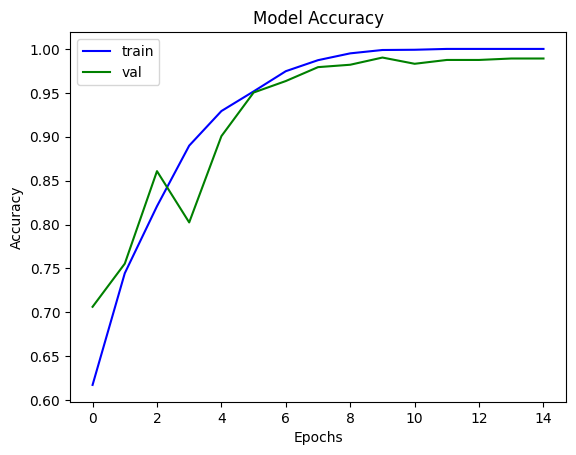

In [14]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

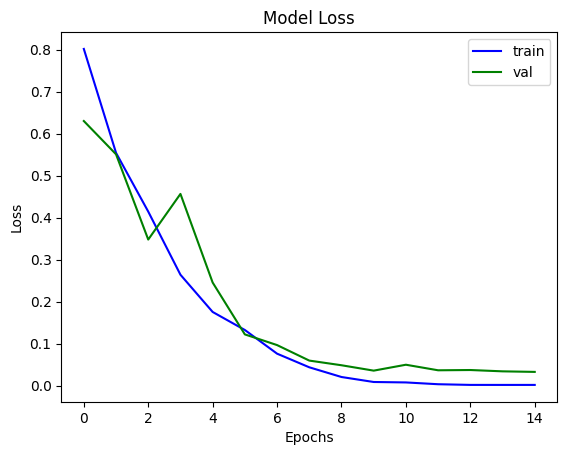

In [15]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

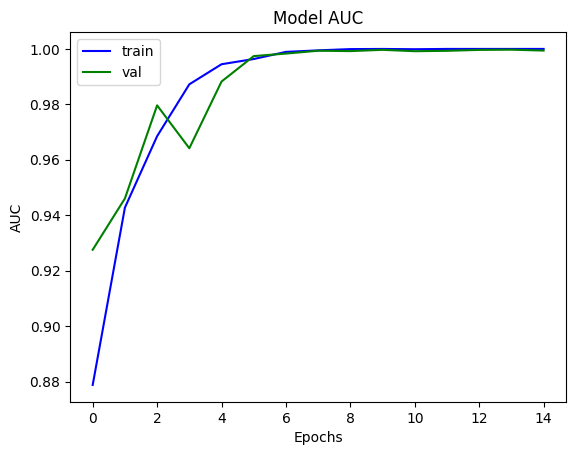

In [16]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

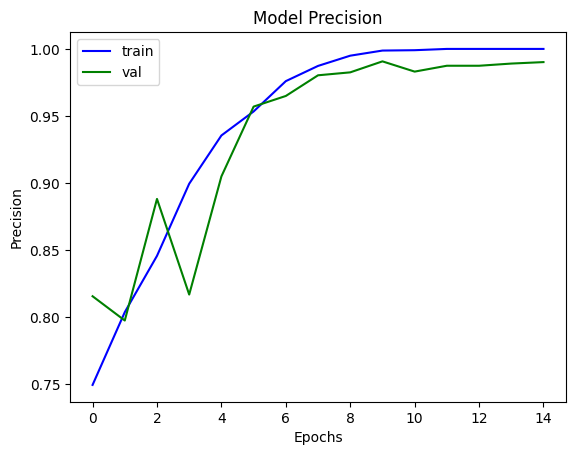

In [17]:
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

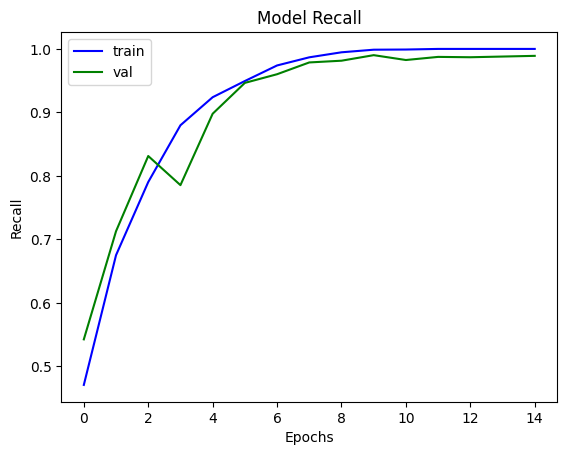

In [18]:
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

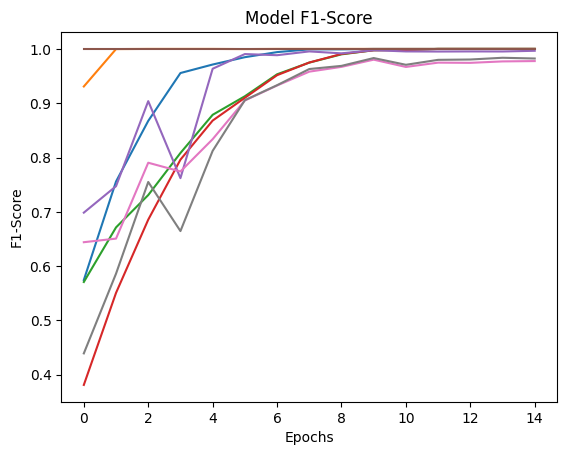

In [19]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title("Model F1-Score")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.show()

### <font color=orange> evaluation using test data </font>
- Evaluation
- Classification report
- Confusion matrix
- ROC curve


In [20]:
### Evaluate Model
test_scores = RecallNET.evaluate(x_test, y_test, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AUC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((test_scores[3][0] + test_scores[3][1] + test_scores[3][2] + test_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[5] * 100))

58/58 [==============================] - 7s 115ms/step - loss: 0.0209 - acc: 0.9929 - auc: 0.9999 - f1_score: 0.9927 - precision: 0.9929 - recall: 0.9918


Testing Loss : 		 0.020915
Testing Accuracy : 	 99.291551 %
Testing AUC : 		 99.992299 %
Testing F1-Score : 	 99.273485 %
Testing Precision : 	 99.290782 %
Testing Recall : 	 99.182564 %


In [21]:
pred_labels = RecallNET.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))


58/58 [==============================] - 7s 116ms/step
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00       454
ModerateDemented       1.00      1.00      1.00       488
     NonDemented       0.99      0.99      0.99       452
VeryMildDemented       0.99      0.99      0.99       441

       micro avg       0.99      0.99      0.99      1835
       macro avg       0.99      0.99      0.99      1835
    weighted avg       0.99      0.99      0.99      1835
     samples avg       0.99      0.99      0.99      1835



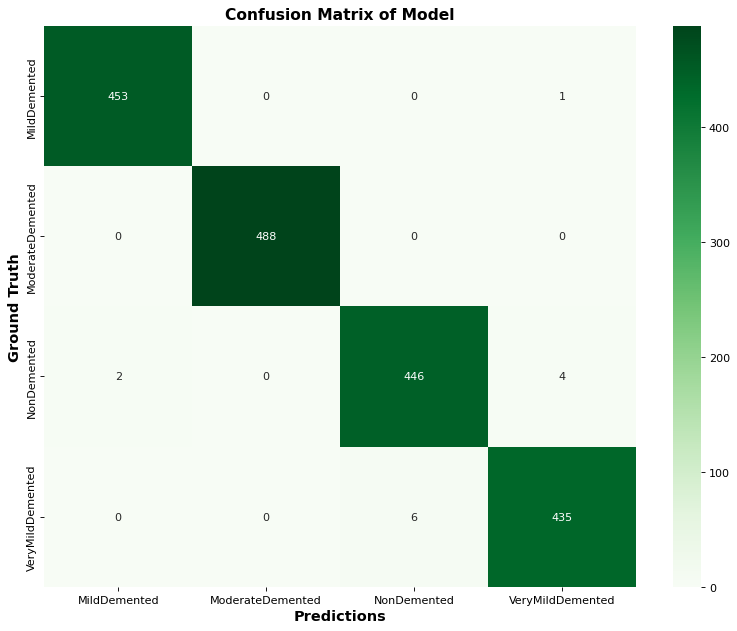

In [22]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

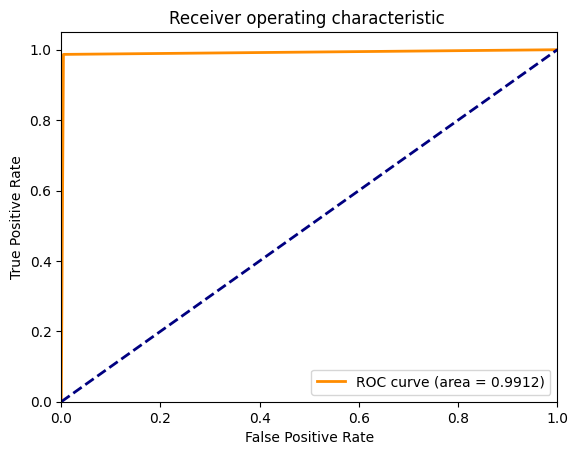

In [23]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

### <font color=orange> evaluation using unbalanced sample </font>
- Evaluation
- Classification report
- Confusion matrix
- ROC curve

In [24]:
### evaluation with unbalanced data
unbal_scores = RecallNET.evaluate(unbal_x, unbal_y, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(unbal_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(unbal_scores[1] * 100))
print("Testing AUC : \t\t {0:0.6f} %".format(unbal_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((unbal_scores[3][0] + unbal_scores[3][1] + unbal_scores[3][2] + unbal_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(unbal_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(unbal_scores[5] * 100))

20/20 [==============================] - 3s 117ms/step - loss: 0.0607 - acc: 0.9766 - auc: 0.9993 - f1_score: 0.9846 - precision: 0.9766 - recall: 0.9766


Testing Loss : 		 0.060676
Testing Accuracy : 	 97.656250 %
Testing AUC : 		 99.930948 %
Testing F1-Score : 	 98.459530 %
Testing Precision : 	 97.656250 %
Testing Recall : 	 97.656250 %


In [25]:
pred_labels_unbal = RecallNET.predict(unbal_x, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels_unbal in pred_labels_unbal:
    labels_unbal = roundoff(labels_unbal)

print(classification_report(unbal_y, pred_labels_unbal, target_names=CLASSES))

20/20 [==============================] - 2s 116ms/step
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99        83
ModerateDemented       1.00      1.00      1.00         8
     NonDemented       0.99      0.97      0.98       334
VeryMildDemented       0.95      0.98      0.97       215

       micro avg       0.98      0.98      0.98       640
       macro avg       0.98      0.99      0.98       640
    weighted avg       0.98      0.98      0.98       640
     samples avg       0.98      0.98      0.98       640



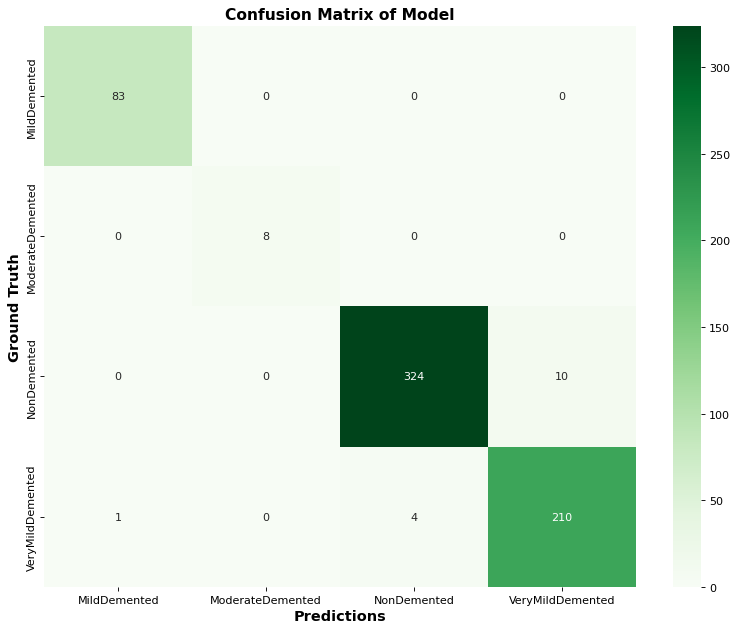

In [26]:
pred_ls_unbal = np.argmax(pred_labels_unbal, axis=1)
test_ls_unbal = np.argmax(unbal_y, axis=1)

conf_arr_unbal = confusion_matrix(test_ls_unbal, pred_ls_unbal)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr_unbal, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

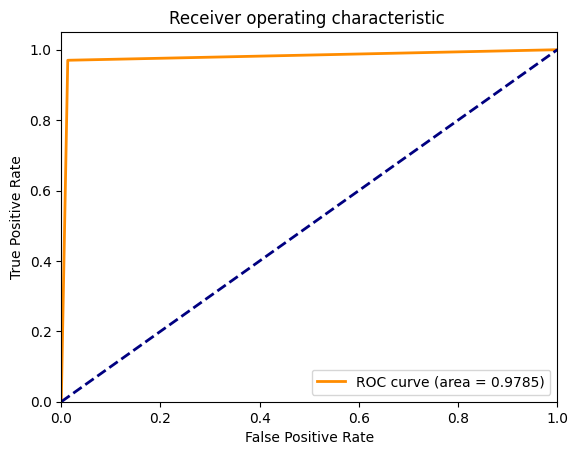

In [27]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(unbal_y[:, i], pred_labels_unbal[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(unbal_y.ravel(), pred_labels_unbal.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

## **<font color=orange> RecallNET+Attention model </font>**

### <font color=orange> architecture </font>

In [28]:
inputs = Input(shape = (176, 208, 3))

conv1 = Convolution2D(16, 1, kernel_initializer=init)(inputs)
norm1 = GroupNormalization(groups = -1)(conv1)
relu1 = ReLU()(norm1)
pool1 = AveragePooling2D(pool_size=(2,2))(relu1)

conv2 = Convolution2D(32, 5, kernel_initializer=init)(pool1)
norm2 = GroupNormalization(groups=-1)(conv2)
relu2 = ReLU()(norm2)
pool2 = AveragePooling2D(pool_size=(2,2))(relu2)

conv3 = Convolution2D(64, 5, kernel_initializer=init)(pool2)
norm3 = GroupNormalization(groups=-1)(conv3)
relu3 = ReLU()(norm3)
pool3 = AveragePooling2D(pool_size=(2,2))(relu3)

conv4 = Convolution2D(128, 5, kernel_initializer=init)(pool3)
norm4 = GroupNormalization(groups=-1)(conv4)
relu4 = ReLU()(norm4)
pool4 = AveragePooling2D(pool_size=(2,2))(relu4)

attn = Attention()([pool4, pool4])

drop1 = Dropout(0.01)(attn)

flattened = Flatten()(drop1)

dense1 = Dense(256, kernel_initializer=init)(flattened)
relu5 = ReLU()(dense1)
drop2 = Dropout(0.03)(relu5)

dense2 = Dense(4, kernel_initializer=init)(drop2)
soft = Softmax()(dense2)

RecallNETAtt = Model(inputs = inputs, outputs = soft)

RecallNETAtt.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 176, 208, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 176, 208, 16)         64        ['input_2[0][0]']             
                                                                                                  
 group_normalization_4 (Gro  (None, 176, 208, 16)         32        ['conv2d_4[0][0]']            
 upNormalization)                                                                                 
                                                                                                  
 re_lu_5 (ReLU)              (None, 176, 208, 16)         0         ['group_normalization_4[0]

### <font color=orange> compile model </font>

In [29]:
### Model Compilation
RecallNETAtt.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=4),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])


### <font color=orange> train model </font>

In [30]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = RecallNETAtt.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 15,
batch_size=batch_size,
callbacks = CALLBACKS
)

Epoch 1/15


917/917 [==============================] - 185s 201ms/step - loss: 0.8476 - acc: 0.6052 - auc: 0.8653 - f1_score: 0.6001 - precision: 0.7229 - recall: 0.4613 - val_loss: 0.6456 - val_acc: 0.6845 - val_auc: 0.9186 - val_f1_score: 0.6792 - val_precision: 0.7722 - val_recall: 0.5590 - lr: 0.0100
Epoch 2/15
917/917 [==============================] - 192s 209ms/step - loss: 0.6117 - acc: 0.7166 - auc: 0.9296 - f1_score: 0.7154 - precision: 0.7815 - recall: 0.6341 - val_loss: 0.4769 - val_acc: 0.7953 - val_auc: 0.9615 - val_f1_score: 0.7917 - val_precision: 0.8510 - val_recall: 0.7200 - lr: 0.0100
Epoch 3/15
917/917 [==============================] - 188s 205ms/step - loss: 0.4959 - acc: 0.7788 - auc: 0.9548 - f1_score: 0.7786 - precision: 0.8161 - recall: 0.7336 - val_loss: 0.3835 - val_acc: 0.8395 - val_auc: 0.9757 - val_f1_score: 0.8345 - val_precision: 0.8651 - val_recall: 0.8090 - lr: 0.0100
Epoch 4/15
917/917 [==============================] - 191s 208ms/step - loss: 0.3780 - acc: 0.83

### <font color=orange> model training graphs </font>
- Accuracy
- Loss
- AUC
- Precision
- Recall
- F1-Score

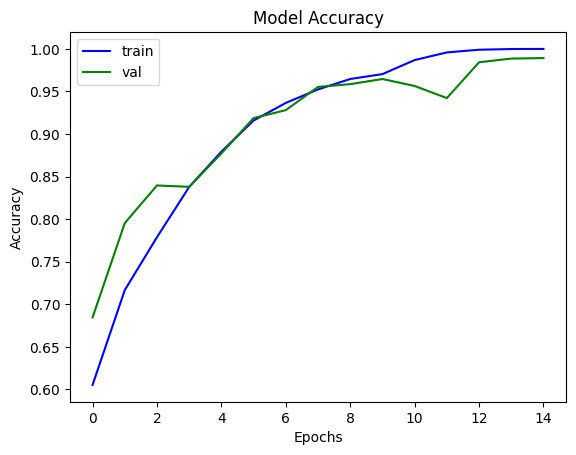

In [31]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

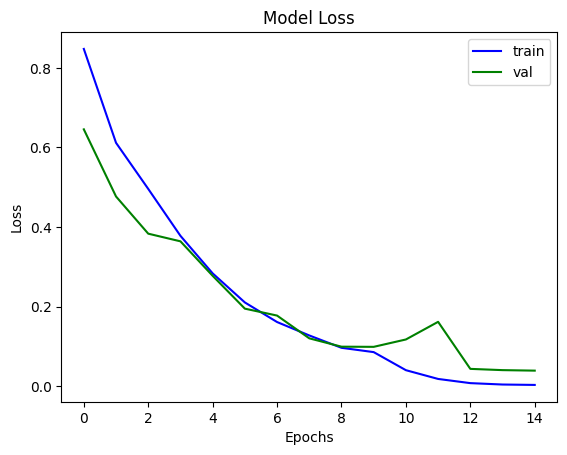

In [32]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

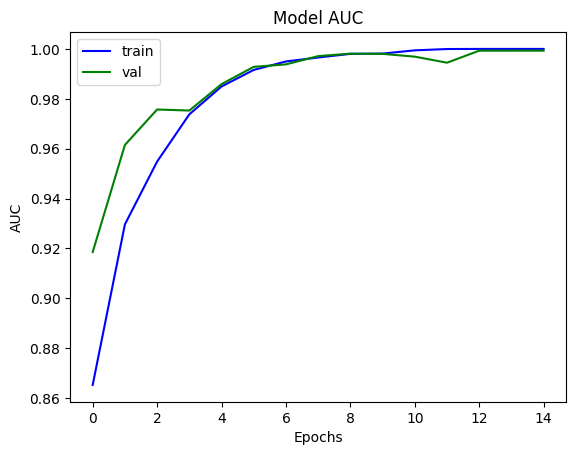

In [33]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

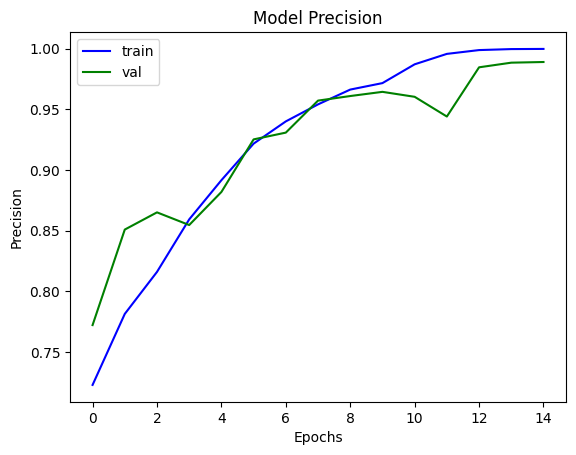

In [34]:
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

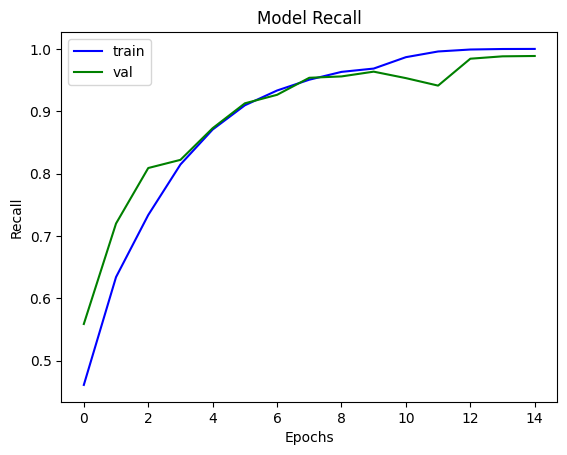

In [35]:
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

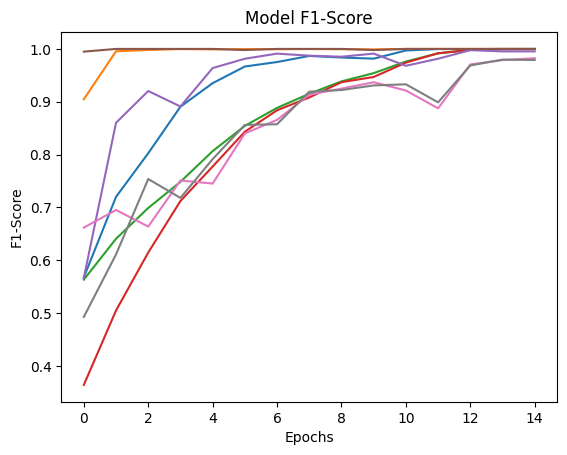

In [36]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title("Model F1-Score")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.show()

### <font color=orange> evaluation using test data </font>
- Evaluation
- Classification report
- Confusion matrix
- ROC curve

In [37]:
### Evaluate Model
test_scores = RecallNETAtt.evaluate(x_test, y_test, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AUC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((test_scores[3][0] + test_scores[3][1] + test_scores[3][2] + test_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[5] * 100))

58/58 [==============================] - 8s 135ms/step - loss: 0.0331 - acc: 0.9896 - auc: 0.9991 - f1_score: 0.9894 - precision: 0.9902 - recall: 0.9891


Testing Loss : 		 0.033102
Testing Accuracy : 	 98.964578 %
Testing AUC : 		 99.907792 %
Testing F1-Score : 	 98.936743 %
Testing Precision : 	 99.018002 %
Testing Recall : 	 98.910081 %


In [38]:
pred_labels = RecallNETAtt.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))


58/58 [==============================] - 7s 114ms/step
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00       454
ModerateDemented       1.00      1.00      1.00       488
     NonDemented       0.98      0.98      0.98       452
VeryMildDemented       0.98      0.98      0.98       441

       micro avg       0.99      0.99      0.99      1835
       macro avg       0.99      0.99      0.99      1835
    weighted avg       0.99      0.99      0.99      1835
     samples avg       0.99      0.99      0.99      1835



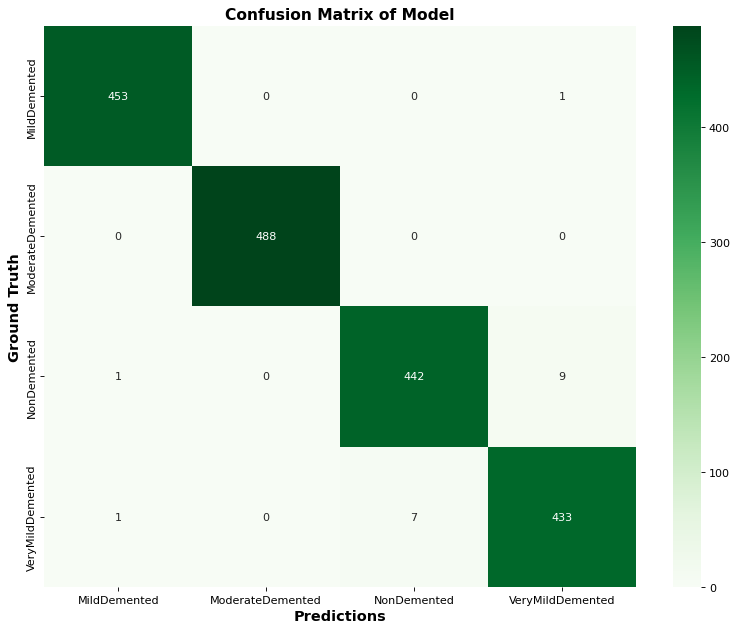

In [39]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

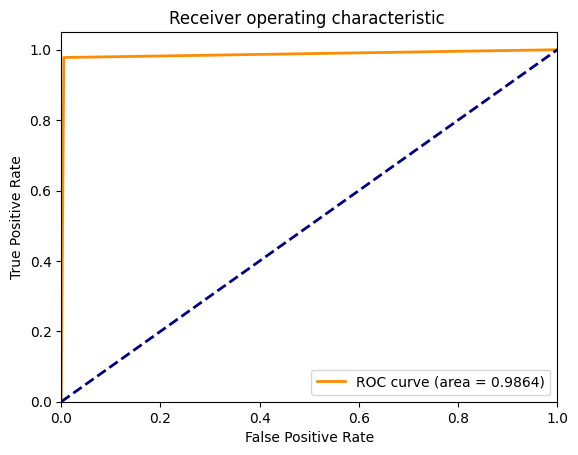

In [40]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

### <font color=orange> evaluation using unbalanced sample </font>
- Evaluation
- Classification report
- Confusion matrix
- ROC curve

In [41]:
### evaluation with unbalanced data
unbal_scores = RecallNETAtt.evaluate(unbal_x, unbal_y, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(unbal_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(unbal_scores[1] * 100))
print("Testing AUC : \t\t {0:0.6f} %".format(unbal_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((unbal_scores[3][0] + unbal_scores[3][1] + unbal_scores[3][2] + unbal_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(unbal_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(unbal_scores[5] * 100))

20/20 [==============================] - 3s 119ms/step - loss: 0.1037 - acc: 0.9641 - auc: 0.9970 - f1_score: 0.9738 - precision: 0.9640 - recall: 0.9625


Testing Loss : 		 0.103696
Testing Accuracy : 	 96.406251 %
Testing AUC : 		 99.701464 %
Testing F1-Score : 	 97.379684 %
Testing Precision : 	 96.400625 %
Testing Recall : 	 96.249998 %


In [42]:
pred_labels_unbal = RecallNETAtt.predict(unbal_x, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels_unbal in pred_labels_unbal:
    labels_unbal = roundoff(labels_unbal)

print(classification_report(unbal_y, pred_labels_unbal, target_names=CLASSES))

20/20 [==============================] - 3s 126ms/step
                  precision    recall  f1-score   support

    MildDemented       0.95      1.00      0.98        83
ModerateDemented       1.00      1.00      1.00         8
     NonDemented       0.98      0.96      0.97       334
VeryMildDemented       0.95      0.95      0.95       215

       micro avg       0.96      0.96      0.96       640
       macro avg       0.97      0.98      0.97       640
    weighted avg       0.96      0.96      0.96       640
     samples avg       0.96      0.96      0.96       640



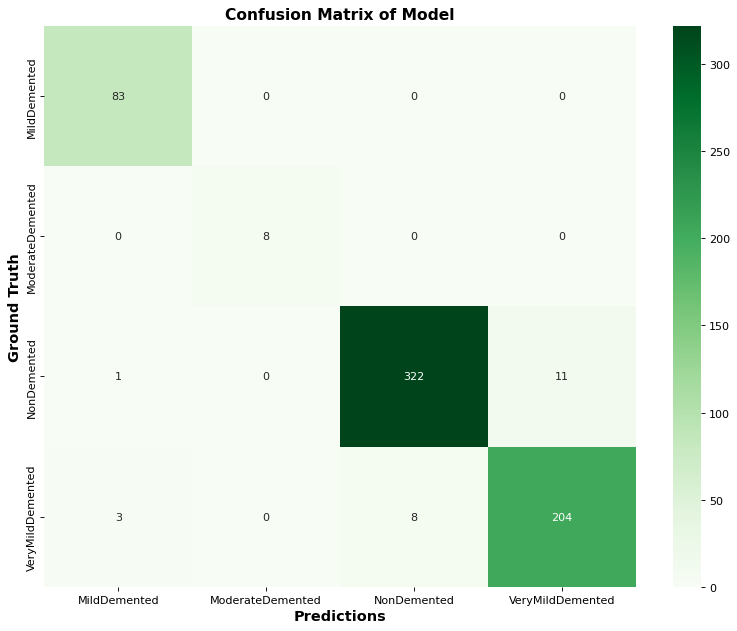

In [43]:
pred_ls_unbal = np.argmax(pred_labels_unbal, axis=1)
test_ls_unbal = np.argmax(unbal_y, axis=1)

conf_arr_unbal = confusion_matrix(test_ls_unbal, pred_ls_unbal)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr_unbal, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

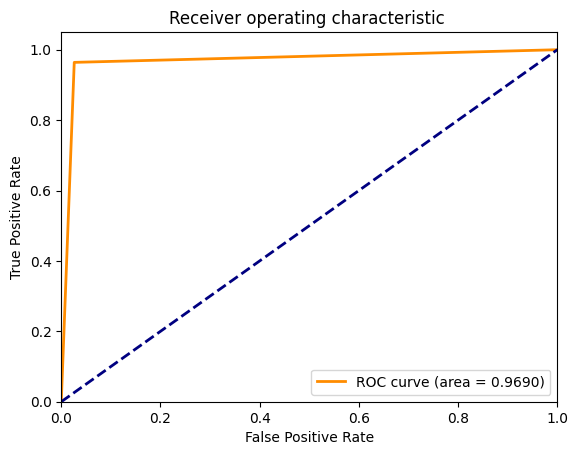

In [44]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(unbal_y[:, i], pred_labels_unbal[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(unbal_y.ravel(), pred_labels_unbal.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

## **<font color=orange> Baseline ADD-Net model </font>**

### <font color=orange> architecture </font>

In [45]:
ADDnet = Sequential()

ADDnet.add(Input(shape=(176, 208, 3)))

ADDnet.add(Convolution2D(16, 5, kernel_initializer=init))
ADDnet.add(ReLU())
ADDnet.add(AveragePooling2D(pool_size=(2,2)))

ADDnet.add(Convolution2D(32, 5, kernel_initializer=init))
ADDnet.add(ReLU())
ADDnet.add(AveragePooling2D(pool_size=(2,2)))

ADDnet.add(Convolution2D(64, 5, kernel_initializer=init))
ADDnet.add(ReLU())
ADDnet.add(AveragePooling2D(pool_size=(2,2)))

ADDnet.add(Convolution2D(128, 5, kernel_initializer=init))
ADDnet.add(ReLU())
ADDnet.add(AveragePooling2D(pool_size=(2,2)))

ADDnet.add(Dropout(0.01))

ADDnet.add(Flatten())

ADDnet.add(Dense(256, kernel_initializer=init))
ADDnet.add(ReLU())
ADDnet.add(Dropout(0.03))

ADDnet.add(Dense(4, kernel_initializer=init))
ADDnet.add(Softmax())

ADDnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 172, 204, 16)      1216      
                                                                 
 re_lu_10 (ReLU)             (None, 172, 204, 16)      0         
                                                                 
 average_pooling2d_8 (Avera  (None, 86, 102, 16)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_9 (Conv2D)           (None, 82, 98, 32)        12832     
                                                                 
 re_lu_11 (ReLU)             (None, 82, 98, 32)        0         
                                                                 
 average_pooling2d_9 (Avera  (None, 41, 49, 32)        0         
 gePooling2D)                                         

### <font color=orange> compile model </font>

In [46]:
### Model Compilation
ADDnet.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=4),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])


### <font color=orange> train model </font>

In [47]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = ADDnet.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 15,
batch_size=batch_size,
callbacks = CALLBACKS
)

Epoch 1/15


917/917 [==============================] - 153s 167ms/step - loss: 1.2414 - acc: 0.3974 - auc: 0.6821 - f1_score: 0.3843 - precision: 0.6952 - recall: 0.1216 - val_loss: 0.8392 - val_acc: 0.6212 - val_auc: 0.8771 - val_f1_score: 0.5930 - val_precision: 0.7581 - val_recall: 0.3968 - lr: 0.0100
Epoch 2/15
917/917 [==============================] - 244s 266ms/step - loss: 0.7550 - acc: 0.6362 - auc: 0.8914 - f1_score: 0.6305 - precision: 0.7503 - recall: 0.5016 - val_loss: 0.6323 - val_acc: 0.7183 - val_auc: 0.9286 - val_f1_score: 0.7176 - val_precision: 0.8410 - val_recall: 0.5197 - lr: 0.0100
Epoch 3/15
917/917 [==============================] - 154s 168ms/step - loss: 0.6317 - acc: 0.7122 - auc: 0.9251 - f1_score: 0.7104 - precision: 0.7802 - recall: 0.6100 - val_loss: 0.6323 - val_acc: 0.7091 - val_auc: 0.9248 - val_f1_score: 0.6919 - val_precision: 0.7326 - val_recall: 0.6790 - lr: 0.0100
Epoch 4/15
917/917 [==============================] - 158s 172ms/step - loss: 0.5398 - acc: 0.75

### <font color=orange> evaluation using test data </font>
- Evaluation
- Classification report
- Confusion matrix

In [48]:
### Evaluate Model
test_scores = ADDnet.evaluate(x_test, y_test, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AUC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((test_scores[3][0] + test_scores[3][1] + test_scores[3][2] + test_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[5] * 100))

58/58 [==============================] - 6s 97ms/step - loss: 0.0545 - acc: 0.9842 - auc: 0.9985 - f1_score: 0.9838 - precision: 0.9842 - recall: 0.9842


Testing Loss : 		 0.054468
Testing Accuracy : 	 98.419619 %
Testing AUC : 		 99.851477 %
Testing F1-Score : 	 98.375845 %
Testing Precision : 	 98.419619 %
Testing Recall : 	 98.419619 %


In [49]:
pred_labels = ADDnet.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))


58/58 [==============================] - 6s 94ms/step
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      1.00       454
ModerateDemented       1.00      1.00      1.00       488
     NonDemented       0.97      0.97      0.97       452
VeryMildDemented       0.97      0.97      0.97       441

       micro avg       0.98      0.98      0.98      1835
       macro avg       0.98      0.98      0.98      1835
    weighted avg       0.98      0.98      0.98      1835
     samples avg       0.98      0.98      0.98      1835



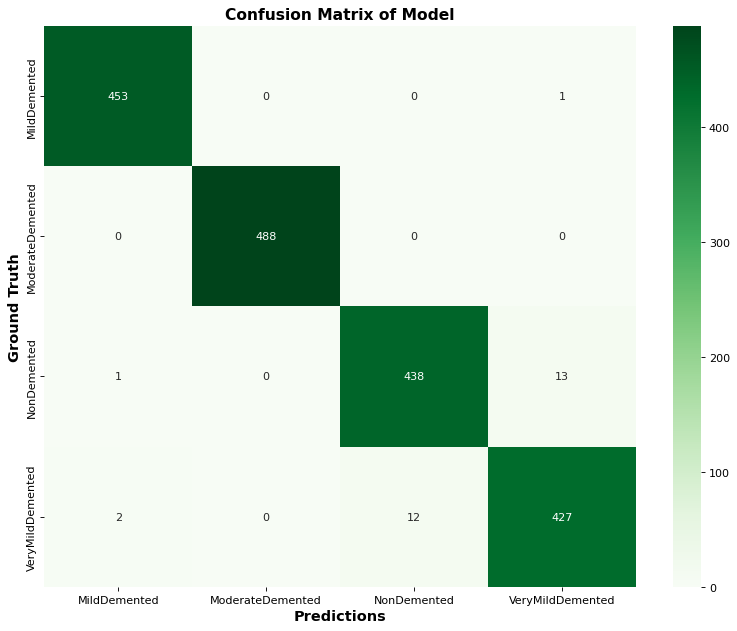

In [50]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

### <font color=orange> evaluation using unbalanced sample </font>
- Evaluation
- Classification report
- Confusion matrix

In [51]:
### evaluation with unbalanced data
unbal_scores = ADDnet.evaluate(unbal_x, unbal_y, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(unbal_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(unbal_scores[1] * 100))
print("Testing AUC : \t\t {0:0.6f} %".format(unbal_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((unbal_scores[3][0] + unbal_scores[3][1] + unbal_scores[3][2] + unbal_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(unbal_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(unbal_scores[5] * 100))


20/20 [==============================] - 2s 93ms/step - loss: 0.1438 - acc: 0.9438 - auc: 0.9957 - f1_score: 0.9613 - precision: 0.9452 - recall: 0.9438


Testing Loss : 		 0.143832
Testing Accuracy : 	 94.375002 %
Testing AUC : 		 99.573320 %
Testing F1-Score : 	 96.134162 %
Testing Precision : 	 94.522691 %
Testing Recall : 	 94.375002 %


In [52]:
pred_labels_unbal = ADDnet.predict(unbal_x, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels_unbal in pred_labels_unbal:
    labels_unbal = roundoff(labels_unbal)

print(classification_report(unbal_y, pred_labels_unbal, target_names=CLASSES))

20/20 [==============================] - 2s 100ms/step
                  precision    recall  f1-score   support

    MildDemented       0.96      0.99      0.98        83
ModerateDemented       1.00      1.00      1.00         8
     NonDemented       0.97      0.94      0.95       334
VeryMildDemented       0.90      0.93      0.92       215

       micro avg       0.94      0.94      0.94       640
       macro avg       0.96      0.96      0.96       640
    weighted avg       0.94      0.94      0.94       640
     samples avg       0.94      0.94      0.94       640



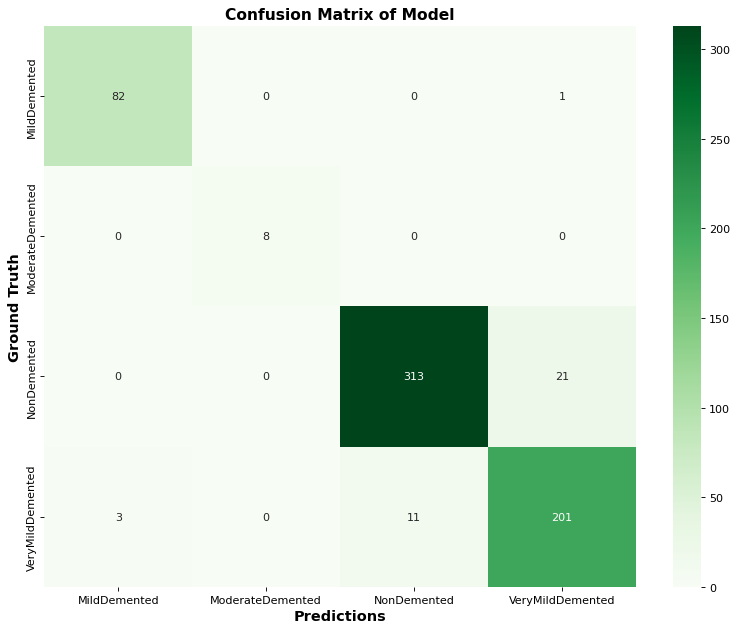

In [53]:
pred_ls_unbal = np.argmax(pred_labels_unbal, axis=1)
test_ls_unbal = np.argmax(unbal_y, axis=1)

conf_arr_unbal = confusion_matrix(test_ls_unbal, pred_ls_unbal)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr_unbal, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

## **<font color=orange> ADD-Net+Attention model </font>**

### <font color=orange> architecture </font>

In [54]:
inputs = Input(shape = (176, 208, 3))

conv1 = Convolution2D(16, 5, kernel_initializer=init)(inputs)
relu1 = ReLU()(conv1)
pool1 = AveragePooling2D(pool_size=(2,2))(relu1)

conv2 = Convolution2D(32, 5, kernel_initializer=init)(pool1)
relu2 = ReLU()(conv2)
pool2 = AveragePooling2D(pool_size=(2,2))(relu2)

conv3 = Convolution2D(64, 5, kernel_initializer=init)(pool2)
relu3 = ReLU()(conv3)
pool3 = AveragePooling2D(pool_size=(2,2))(relu3)

conv4 = Convolution2D(128, 5, kernel_initializer=init)(pool3)
relu4 = ReLU()(conv4)
pool4 = AveragePooling2D(pool_size=(2,2))(relu4)

attn = Attention()([pool4, pool4])

drop1 = Dropout(0.01)(attn)

flattened = Flatten()(drop1)

dense1 = Dense(256, kernel_initializer=init)(flattened)
relu5 = ReLU()(dense1)
drop2 = Dropout(0.03)(relu5)

dense2 = Dense(4, kernel_initializer=init)(drop2)
soft = Softmax()(dense2)

ADDnetAtt = Model(inputs = inputs, outputs = soft)

ADDnetAtt.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 176, 208, 3)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 172, 204, 16)         1216      ['input_4[0][0]']             
                                                                                                  
 re_lu_15 (ReLU)             (None, 172, 204, 16)         0         ['conv2d_12[0][0]']           
                                                                                                  
 average_pooling2d_12 (Aver  (None, 86, 102, 16)          0         ['re_lu_15[0][0]']            
 agePooling2D)                                                                              

### <font color=orange> compile model </font>

In [55]:
### Model Compilation
ADDnetAtt.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=4),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])


### <font color=orange> train model </font>

In [56]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = ADDnetAtt.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 15,
batch_size=batch_size,
callbacks = CALLBACKS
)

Epoch 1/15


917/917 [==============================] - 152s 166ms/step - loss: 1.3810 - acc: 0.2767 - auc: 0.5361 - f1_score: 0.2601 - precision: 0.7500 - recall: 4.0894e-04 - val_loss: 1.3717 - val_acc: 0.2686 - val_auc: 0.5513 - val_f1_score: 0.1486 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 2/15
917/917 [==============================] - 160s 175ms/step - loss: 1.3537 - acc: 0.3274 - auc: 0.5947 - f1_score: 0.3073 - precision: 0.5094 - recall: 0.0110 - val_loss: 1.3678 - val_acc: 0.2991 - val_auc: 0.5850 - val_f1_score: 0.2264 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 3/15
917/917 [==============================] - 161s 176ms/step - loss: 1.1447 - acc: 0.4789 - auc: 0.7488 - f1_score: 0.4700 - precision: 0.6812 - recall: 0.2199 - val_loss: 0.8344 - val_acc: 0.5933 - val_auc: 0.8696 - val_f1_score: 0.5175 - val_precision: 0.6910 - val_recall: 0.5164 - lr: 0.0100
Epoch 4/15
917/917 [==============================] - 160s 174ms/step - loss

### <font color=orange> evaluation using test data </font>
- Evaluation
- Classification report
- Confusion matrix

In [57]:
### Evaluate Model
test_scores = ADDnetAtt.evaluate(x_test, y_test, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AUC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((test_scores[3][0] + test_scores[3][1] + test_scores[3][2] + test_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[5] * 100))

58/58 [==============================] - 8s 136ms/step - loss: 0.1739 - acc: 0.9313 - auc: 0.9928 - f1_score: 0.9292 - precision: 0.9333 - recall: 0.9308


Testing Loss : 		 0.173940
Testing Accuracy : 	 93.133515 %
Testing AUC : 		 99.283761 %
Testing F1-Score : 	 92.918944 %
Testing Precision : 	 93.333334 %
Testing Recall : 	 93.079019 %


In [58]:
pred_labels = ADDnetAtt.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))


58/58 [==============================] - 9s 147ms/step
                  precision    recall  f1-score   support

    MildDemented       0.98      1.00      0.99       454
ModerateDemented       1.00      1.00      1.00       488
     NonDemented       0.88      0.85      0.87       452
VeryMildDemented       0.86      0.87      0.86       441

       micro avg       0.93      0.93      0.93      1835
       macro avg       0.93      0.93      0.93      1835
    weighted avg       0.93      0.93      0.93      1835
     samples avg       0.93      0.93      0.93      1835



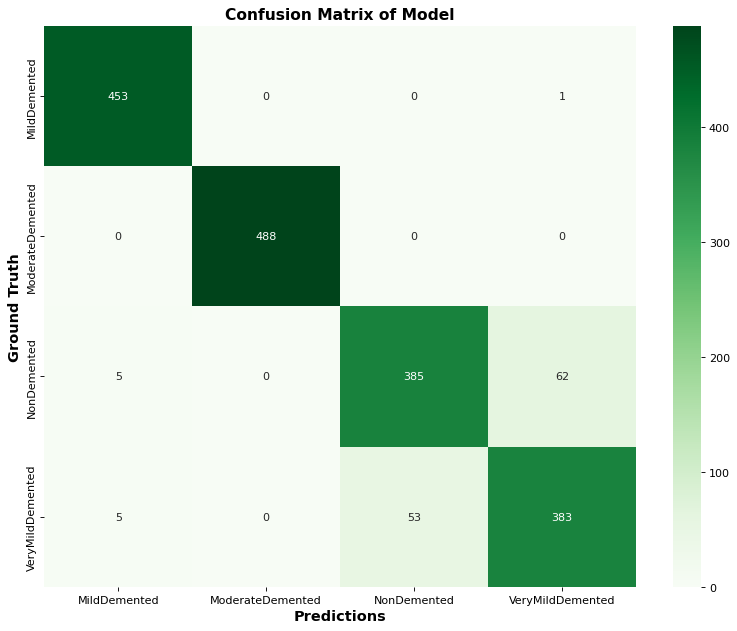

In [59]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

### <font color=orange> evaluation using unbalanced sample </font>
- Evaluation
- Classification report
- Confusion matrix

In [60]:
### evaluation with unbalanced data
unbal_scores = ADDnetAtt.evaluate(unbal_x, unbal_y, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(unbal_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(unbal_scores[1] * 100))
print("Testing AUC : \t\t {0:0.6f} %".format(unbal_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((unbal_scores[3][0] + unbal_scores[3][1] + unbal_scores[3][2] + unbal_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(unbal_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(unbal_scores[5] * 100))


20/20 [==============================] - 3s 143ms/step - loss: 0.3968 - acc: 0.8438 - auc: 0.9706 - f1_score: 0.8922 - precision: 0.8460 - recall: 0.8328


Testing Loss : 		 0.396820
Testing Accuracy : 	 84.375000 %
Testing AUC : 		 97.059661 %
Testing F1-Score : 	 89.224321 %
Testing Precision : 	 84.603173 %
Testing Recall : 	 83.281249 %


In [61]:
pred_labels_unbal = ADDnetAtt.predict(unbal_x, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels_unbal in pred_labels_unbal:
    labels_unbal = roundoff(labels_unbal)

print(classification_report(unbal_y, pred_labels_unbal, target_names=CLASSES))

20/20 [==============================] - 3s 136ms/step
                  precision    recall  f1-score   support

    MildDemented       0.91      0.94      0.92        83
ModerateDemented       1.00      1.00      1.00         8
     NonDemented       0.88      0.84      0.86       334
VeryMildDemented       0.77      0.81      0.79       215

       micro avg       0.84      0.84      0.84       640
       macro avg       0.89      0.90      0.89       640
    weighted avg       0.85      0.84      0.84       640
     samples avg       0.84      0.84      0.84       640



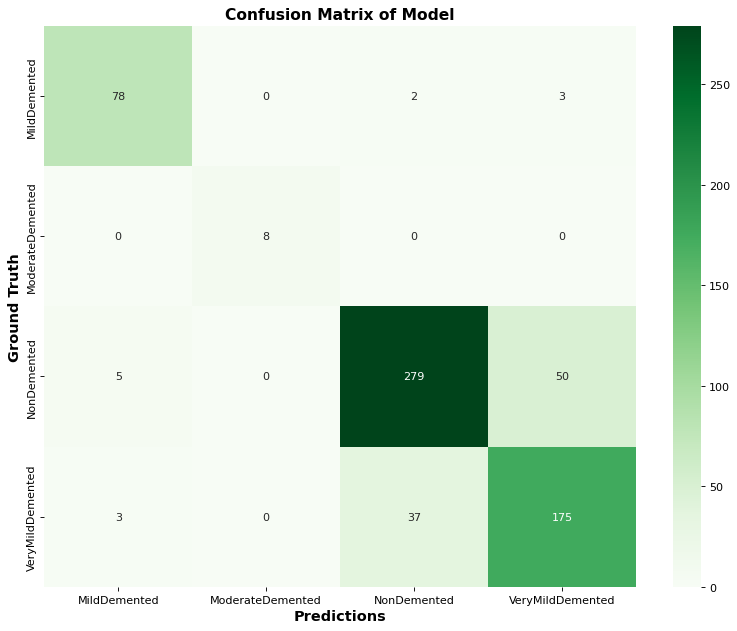

In [62]:
pred_ls_unbal = np.argmax(pred_labels_unbal, axis=1)
test_ls_unbal = np.argmax(unbal_y, axis=1)

conf_arr_unbal = confusion_matrix(test_ls_unbal, pred_ls_unbal)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr_unbal, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

## <font color=purple> Save each model </font>

In [63]:
# save the models for future use
RecallNET.save(".\\RecallNET.h5")
RecallNETAtt.save(".\\RecallNETAtt.h5")
ADDnet.save(".\\ADDnet.h5")
ADDnetAtt.save(".\\ADDnetAtt.h5")

c:\Users\amyti\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
